##### Copyright 2019 The TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Post-training float16 quantization

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/lite/performance/post_training_float16_quant"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/tensorflow/blob/master/tensorflow/lite/g3doc/performance/post_training_float16_quant.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/tensorflow/blob/master/tensorflow/lite/g3doc/performance/post_training_float16_quant.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/tensorflow/lite/g3doc/performance/post_training_float16_quant.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

## Overview

[TensorFlow Lite](https://www.tensorflow.org/lite/) now supports
converting weights to 16-bit floating point values during model conversion from TensorFlow to TensorFlow Lite's flat buffer format. This results in a 2x reduction in model size. Some hardware, like GPUs, can compute natively in this reduced precision arithmetic, realizing a speedup over traditional floating point execution. The Tensorflow Lite GPU delegate can be configured to run in this way. However, a model converted to float16 weights can still run on the CPU without additional modification: the float16 weights are upsampled to float32 prior to the first inference. This permits a significant reduction in model size in exchange for a minimal impacts to latency and accuracy.

In this tutorial, you train an MNIST model from scratch, check its accuracy in TensorFlow, and then convert the model into a Tensorflow Lite flatbuffer
with float16 quantization. Finally, check the accuracy of the converted model and compare it to the original float32 model.

## Build an MNIST model

### Setup

In [1]:
import logging
logging.getLogger("tensorflow").setLevel(logging.DEBUG)

import tensorflow as tf
from tensorflow import keras
import numpy as np
import pathlib

In [2]:
tf.float16

tf.float16

### Train and export the model

In [3]:
# Load MNIST dataset
mnist = keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

# Normalize the input image so that each pixel value is between 0 to 1.
train_images = train_images / 255.0
test_images = test_images / 255.0

# Define the model architecture
model = keras.Sequential([
  keras.layers.InputLayer(input_shape=(28, 28)),
  keras.layers.Reshape(target_shape=(28, 28, 1)),
  keras.layers.Conv2D(filters=12, kernel_size=(3, 3), activation=tf.nn.relu),
  keras.layers.MaxPooling2D(pool_size=(2, 2)),
  keras.layers.Flatten(),
  keras.layers.Dense(10)
])

# Train the digit classification model
model.compile(optimizer='adam',
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.fit(
  train_images,
  train_labels,
  epochs=1,
  validation_data=(test_images, test_labels)
)

1875/1875 [==============================] - 18s 9ms/step - loss: 0.2807 - accuracy: 0.9208 - val_loss: 0.1253 - val_accuracy: 0.9638


For the example, you trained the model for just a single epoch, so it only trains to ~96% accuracy.

### Convert to a TensorFlow Lite model

Using the Python [TFLiteConverter](https://www.tensorflow.org/lite/convert/python_api), you can now convert the trained model into a TensorFlow Lite model.

Now load the model using the `TFLiteConverter`:

In [4]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

INFO:tensorflow:Assets written to: /tmp/tmpj2_92uhc/assets


Write it out to a `.tflite` file:

In [5]:
tflite_models_dir = pathlib.Path("/tmp/mnist_tflite_models/")
tflite_models_dir.mkdir(exist_ok=True, parents=True)

In [6]:
tflite_model_file = tflite_models_dir/"mnist_model.tflite"
tflite_model_file.write_bytes(tflite_model)

84552

To instead quantize the model to float16 on export, first set the `optimizations` flag to use default optimizations. Then specify that float16 is the supported type on the target platform:

In [7]:
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_types = [tf.float16]

Finally, convert the model like usual. Note, by default the converted model will still use float input and outputs for invocation convenience.

In [8]:
tflite_fp16_model = converter.convert()
tflite_model_fp16_file = tflite_models_dir/"mnist_model_quant_f16.tflite"
tflite_model_fp16_file.write_bytes(tflite_fp16_model)

INFO:tensorflow:Assets written to: /tmp/tmpm89j7xkl/assets


INFO:tensorflow:Assets written to: /tmp/tmpm89j7xkl/assets


44432

Note how the resulting file is approximately `1/2` the size.

In [10]:
!ls -lh {tflite_models_dir}

total 128K
-rw-r--r-- 1 root root 44K Jun 12 06:46 mnist_model_quant_f16.tflite
-rw-r--r-- 1 root root 83K Jun 12 06:46 mnist_model.tflite


## Run the TensorFlow Lite models

Run the TensorFlow Lite model using the Python TensorFlow Lite Interpreter.

### Load the model into the interpreters

In [11]:
interpreter = tf.lite.Interpreter(model_path=str(tflite_model_file))
interpreter.allocate_tensors()

In [12]:
interpreter_fp16 = tf.lite.Interpreter(model_path=str(tflite_model_fp16_file))
interpreter_fp16.allocate_tensors()

### Test the models on one image

In [13]:
test_image = np.expand_dims(test_images[0], axis=0).astype(np.float32)

input_index = interpreter.get_input_details()[0]["index"]
output_index = interpreter.get_output_details()[0]["index"]

interpreter.set_tensor(input_index, test_image)
interpreter.invoke()
predictions = interpreter.get_tensor(output_index)

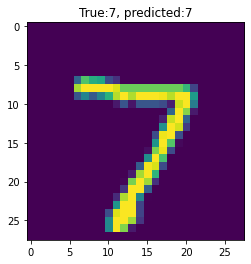

In [14]:
import matplotlib.pylab as plt

plt.imshow(test_images[0])
template = "True:{true}, predicted:{predict}"
_ = plt.title(template.format(true= str(test_labels[0]),
                              predict=str(np.argmax(predictions[0]))))
plt.grid(False)

In [15]:
test_image = np.expand_dims(test_images[0], axis=0).astype(np.float32)

input_index = interpreter_fp16.get_input_details()[0]["index"]
output_index = interpreter_fp16.get_output_details()[0]["index"]

interpreter_fp16.set_tensor(input_index, test_image)
interpreter_fp16.invoke()
predictions = interpreter_fp16.get_tensor(output_index)

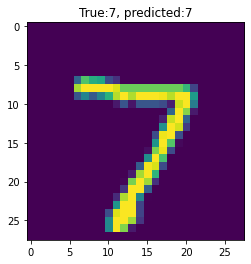

In [16]:
plt.imshow(test_images[0])
template = "True:{true}, predicted:{predict}"
_ = plt.title(template.format(true= str(test_labels[0]),
                              predict=str(np.argmax(predictions[0]))))
plt.grid(False)

### Evaluate the models

In [17]:
# A helper function to evaluate the TF Lite model using "test" dataset.
def evaluate_model(interpreter):
  input_index = interpreter.get_input_details()[0]["index"]
  output_index = interpreter.get_output_details()[0]["index"]

  # Run predictions on every image in the "test" dataset.
  prediction_digits = []
  for test_image in test_images:
    # Pre-processing: add batch dimension and convert to float32 to match with
    # the model's input data format.
    test_image = np.expand_dims(test_image, axis=0).astype(np.float32)
    interpreter.set_tensor(input_index, test_image)

    # Run inference.
    interpreter.invoke()

    # Post-processing: remove batch dimension and find the digit with highest
    # probability.
    output = interpreter.tensor(output_index)
    digit = np.argmax(output()[0])
    prediction_digits.append(digit)

  # Compare prediction results with ground truth labels to calculate accuracy.
  accurate_count = 0
  for index in range(len(prediction_digits)):
    if prediction_digits[index] == test_labels[index]:
      accurate_count += 1
  accuracy = accurate_count * 1.0 / len(prediction_digits)

  return accuracy

In [18]:
print(evaluate_model(interpreter))

0.9638


Repeat the evaluation on the float16 quantized model to obtain:

In [19]:
# NOTE: Colab runs on server CPUs. At the time of writing this, TensorFlow Lite
# doesn't have super optimized server CPU kernels. For this reason this may be
# slower than the above float interpreter. But for mobile CPUs, considerable
# speedup can be observed.
print(evaluate_model(interpreter_fp16))

0.9638


In this example, you have quantized a model to float16 with no difference in the accuracy.

It's also possible to evaluate the fp16 quantized model on the GPU. To perform all arithmetic with the reduced precision values, be sure to create the `TfLiteGPUDelegateOptions` struct in your app and set `precision_loss_allowed` to `1`, like this:

```
//Prepare GPU delegate.
const TfLiteGpuDelegateOptions options = {
  .metadata = NULL,
  .compile_options = {
    .precision_loss_allowed = 1,  // FP16
    .preferred_gl_object_type = TFLITE_GL_OBJECT_TYPE_FASTEST,
    .dynamic_batch_enabled = 0,   // Not fully functional yet
  },
};
```

Detailed documentation on the TFLite GPU delegate and how to use it in your application can be found [here](https://www.tensorflow.org/lite/performance/gpu_advanced?source=post_page---------------------------)